<a href="https://colab.research.google.com/github/enggarpramoto23-a11y/Deep-Learning-Lanjut/blob/main/enggar_XAI_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# PRAKTIKUM: Grad-CAM untuk Interpretabilitas CNN (TensorFlow)
# Dataset: Kaggle - Plant Disease Recognition Dataset (3 kelas)
# ============================================================

!pip -q install kaggle

import os, zipfile, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print("TF version:", tf.__version__)


TF version: 2.19.0


In [2]:
# -----------------------------
# A) UPLOAD kaggle.json dulu
# -----------------------------
# Di Google Colab: klik "Files" -> Upload -> unggah kaggle.json
# kaggle.json didapat dari Kaggle -> Account -> API -> Create New API Token

from google.colab import files
uploaded = files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# -----------------------------
# B) Download dataset
# -----------------------------
# Dataset: rashikrahmanpritom/plant-disease-recognition-dataset
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset -p /content --unzip

# Cek struktur folder hasil unzip
!ls -lah /content


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
License(s): CC0-1.0
 93% 1.16G/1.25G [00:12<00:02, 46.9MB/s]
100% 1.25G/1.25G [00:12<00:00, 106MB/s] 
total 32K
drwxr-xr-x 1 root root 4.0K Jan 26 02:31 .
drwxr-xr-x 1 root root 4.0K Jan 26 02:27 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
-rw-r--r-- 1 root root   69 Jan 26 02:30 kaggle.json
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
drwxr-xr-x 3 root root 4.0K Jan 26 02:31 Test
drwxr-xr-x 3 root root 4.0K Jan 26 02:31 Train
drwxr-xr-x 3 root root 4.0K Jan 26 02:31 Validation


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = "/content/Train/Train"
val_dir   = "/content/Validation/Validation"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Performance pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Classes: ['Healthy', 'Powdery', 'Rust']


In [4]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
train_ds_pf = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds_pf   = val_ds.cache().prefetch(AUTOTUNE)


In [5]:
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = (224, 224)
num_classes = len(class_names)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_ds_pf, validation_data=val_ds_pf, epochs=5)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 676ms/step - accuracy: 0.5570 - loss: 0.9706 - val_accuracy: 0.9500 - val_loss: 0.2230
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9478 - loss: 0.2151 - val_accuracy: 0.9667 - val_loss: 0.1439
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9642 - loss: 0.1457 - val_accuracy: 0.9500 - val_loss: 0.1166
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9742 - loss: 0.1072 - val_accuracy: 0.9667 - val_loss: 0.1094
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9693 - loss: 0.1073 - val_accuracy: 0.9667 - val_loss: 0.0909


In [6]:
def find_last_4d_layer(model):
    # cari layer terakhir yang outputnya 4D: (B,H,W,C)
    for layer in reversed(model.layers):
        try:
            shape = layer.output_shape
            if isinstance(shape, tuple) and len(shape) == 4:
                return layer.name
        except:
            pass
        # kalau layer adalah nested model (base_model), cari di dalamnya
        if isinstance(layer, tf.keras.Model):
            for sub in reversed(layer.layers):
                try:
                    shape = sub.output_shape
                    if isinstance(shape, tuple) and len(shape) == 4:
                        return sub.name
                except:
                    pass
    raise ValueError("Tidak menemukan layer 4D untuk Grad-CAM.")

last_conv_name = find_last_4d_layer(model)
print("Last conv-like (4D) layer:", last_conv_name)


Last conv-like (4D) layer: mobilenetv2_1.00_224


In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def build_gradcam_model(model, base_model, last_conv_layer_name):
    """
    Membuat model:
    input -> feature_map (Conv_1) + output_pred
    """
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    # Ambil classifier head (layer setelah base_model)
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    # Ambil layer-layer classifier dari model utama
    take = False
    for layer in model.layers:
        if layer == base_model:
            take = True
            continue
        if take:
            x = layer(x)

    classifier_model = keras.Model(classifier_input, x)

    # Grad-CAM model: input -> (conv_output, prediction)
    grad_model = keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, classifier_model(last_conv_layer.output)]
    )

    return grad_model


In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name, pred_index=None):
    # 1. Construct the feature extractor model: model's input -> last conv layer's output
    # This feature_extractor operates on the raw image input.
    feature_extractor = keras.Model(
        inputs=model.inputs,
        outputs=base_model.get_layer(last_conv_layer_name).output
    )

    # 2. Reconstruct the classifier head model that takes the output of the last conv layer
    # These are layers AFTER the base_model (mobilenetv2_1.00_224) in the main model.
    # Based on the latest model summary, layer names are: 'global_average_pooling2d_4', 'dropout_2', 'dense_4'.
    classifier_input = keras.Input(shape=feature_extractor.output_shape[1:])
    x = classifier_input
    x = model.get_layer('global_average_pooling2d_4')(x)
    x = model.get_layer('dropout_2')(x)
    outputs_classifier = model.get_layer('dense_4')(x)
    classifier_model = keras.Model(classifier_input, outputs_classifier)

    # 3. Compute gradients of the top predicted class with respect to the activations
    with tf.GradientTape() as tape:
        # Pass the original img_array (raw input) through the feature extractor
        last_conv_layer_output = feature_extractor(img_array)
        tape.watch(last_conv_layer_output) # Watch these activations for gradient calculation

        # Feed the extracted features to the classifier model to get predictions
        preds = classifier_model(last_conv_layer_output)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_score = preds[:, pred_index]

    # Compute gradients of the class score with respect to the last conv layer outputs
    grads = tape.gradient(class_score, last_conv_layer_output)

    # Pool the gradients over all the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    # and then sum all the channels to obtain the heatmap
    last_conv_layer_output = last_conv_layer_output[0] # Remove batch dimension
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(pred_index.numpy()), preds.numpy()[0]

In [9]:
import tensorflow as tf
from tensorflow import keras

# ambil nested model (MobileNetV2) dari model Anda
base_model = None
for layer in model.layers:
    if isinstance(layer, keras.Model):   # nested model
        base_model = layer
        break

print("Base model:", base_model.name if base_model else None)

# lihat 20 layer terakhir MobileNetV2 (opsional, buat pastikan nama layer)
for l in base_model.layers[-20:]:
    try:
        # Access the shape of the output tensor directly
        print(l.name, l.output.shape)
    except AttributeError:
        # Fallback for layers that might not have a direct output tensor attribute (e.g., not yet built)
        print(l.name, "Output tensor shape not available")


Base model: mobilenetv2_1.00_224
block_15_expand (None, 7, 7, 960)
block_15_expand_BN (None, 7, 7, 960)
block_15_expand_relu (None, 7, 7, 960)
block_15_depthwise (None, 7, 7, 960)
block_15_depthwise_BN (None, 7, 7, 960)
block_15_depthwise_relu (None, 7, 7, 960)
block_15_project (None, 7, 7, 160)
block_15_project_BN (None, 7, 7, 160)
block_15_add (None, 7, 7, 160)
block_16_expand (None, 7, 7, 960)
block_16_expand_BN (None, 7, 7, 960)
block_16_expand_relu (None, 7, 7, 960)
block_16_depthwise (None, 7, 7, 960)
block_16_depthwise_BN (None, 7, 7, 960)
block_16_depthwise_relu (None, 7, 7, 960)
block_16_project (None, 7, 7, 320)
block_16_project_BN (None, 7, 7, 320)
Conv_1 (None, 7, 7, 1280)
Conv_1_bn (None, 7, 7, 1280)
out_relu (None, 7, 7, 1280)


In [10]:
last_conv_name = "Conv_1"   # paling direkomendasikan

In [11]:
last_conv_name = "Conv_1"

grad_model = build_gradcam_model(
    model=model,
    base_model=base_model,
    last_conv_layer_name=last_conv_name
)


In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

last_conv_name = "Conv_1"   # sesuai output Anda

# 1) Pastikan base_model yang diambil adalah nested model di dalam model
base_model = None
for layer in model.layers:
    if isinstance(layer, keras.Model) and "mobilenet" in layer.name.lower():
        base_model = layer
        break
print("Base model:", base_model.name)

# 2) Buat extractor conv: base_model.input -> output Conv_1
conv_submodel = keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(last_conv_name).output
)

# 3) Ambil layer-layer head setelah base_model dari model utama
base_index = None
for i, layer in enumerate(model.layers):
    if layer == base_model:
        base_index = i
        break

head_layers = model.layers[base_index+1:]  # biasanya [GlobalAveragePooling2D, Dropout, Dense]
print("Head layers:", [l.name for l in head_layers])

# 4) Rangkai graph: inputs -> preprocess -> conv_outputs -> head -> preds
inputs = model.input
x = keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)(inputs)
conv_outputs = conv_submodel(x)

h = conv_outputs
for layer in head_layers:
    # pastikan Dropout tidak aktif saat Grad-CAM
    if isinstance(layer, keras.layers.Dropout):
        h = layer(h, training=False)
    else:
        h = layer(h)

preds = h  # output softmax
grad_model = keras.Model(inputs, [conv_outputs, preds])

print("grad_model outputs:", grad_model.outputs[0].shape, grad_model.outputs[1].shape)


Base model: mobilenetv2_1.00_224
Head layers: ['global_average_pooling2d', 'dropout', 'dense']
grad_model outputs: (None, 7, 7, 1280) (None, 3)


In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 # Needed for image resizing and colormap
import matplotlib.pyplot as plt # Needed for displaying images

def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)

        # Determine the target index for gradient calculation
        if pred_index is None:
            # If pred_index is None, get the argmax from predictions
            predicted_class_idx = tf.argmax(preds[0])
        else:
            # If pred_index is provided, use it directly
            predicted_class_idx = pred_index

        class_score = preds[:, predicted_class_idx]

    grads = tape.gradient(class_score, conv_outputs)
    if grads is None:
        raise RuntimeError("Gradients None: masih ada graph yang tidak terhubung.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))   # (C,)
    conv_outputs = conv_outputs[0]                          # (H,W,C)

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)  # (H,W)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    # Ensure the returned predicted_class_idx is always a Python int
    if tf.is_tensor(predicted_class_idx):
        predicted_class_idx_int = int(predicted_class_idx.numpy())
    else:
        predicted_class_idx_int = int(predicted_class_idx)

    return heatmap.numpy(), predicted_class_idx_int, preds.numpy()[0]

def display_gradcam(img, heatmap, alpha=0.4):
    """
    Displays the original image overlaid with the Grad-CAM heatmap.
    Args:
        img (np.array): The original image (H, W, 3).
        heatmap (np.array): The Grad-CAM heatmap (H', W').
        alpha (float): Transparency factor for the heatmap.
    """
    # Resize heatmap to be the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap to heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert img to float and normalize to [0, 1]
    img_float = img.astype("float32") / 255.0

    # Convert heatmap to float and normalize to [0, 1]
    heatmap_float = heatmap.astype("float32") / 255.0

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap_float * alpha + img_float * (1 - alpha)
    superimposed_img = (superimposed_img * 255).astype("uint8")

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


True: Healthy
Pred: Healthy | Prob: 0.6077234148979187


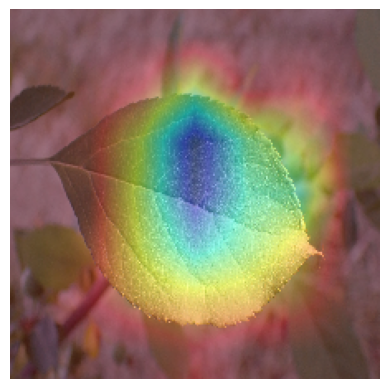

In [17]:
import random

for images, labels in val_ds_pf.take(1):
    break

idx = random.randint(0, images.shape[0]-1)
img = images[idx]
true_label = int(labels[idx].numpy())

img_array = tf.expand_dims(img, axis=0)

heatmap, pred_label, pred_vec = make_gradcam_heatmap(
    img_array, grad_model
)

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label], "| Prob:", float(pred_vec[pred_label]))

display_gradcam(img.numpy().astype("uint8"), heatmap, alpha=0.4)


In [18]:
import numpy as np
import tensorflow as tf

def collect_samples_per_class(dataset, class_names, n_per_class=1, max_batches=50):
    """
    Mengambil n_per_class sampel untuk setiap kelas dari dataset.
    Mengembalikan dict: {class_index: [(img_tensor, label_int), ...]}
    """
    num_classes = len(class_names)
    collected = {i: [] for i in range(num_classes)}

    batches_seen = 0
    for images, labels in dataset:
        batches_seen += 1
        labels_np = labels.numpy()
        for i in range(images.shape[0]):
            y = int(labels_np[i])
            if len(collected[y]) < n_per_class:
                collected[y].append((images[i], y))

        # stop kalau semua kelas sudah cukup
        if all(len(collected[i]) >= n_per_class for i in range(num_classes)):
            break

        if batches_seen >= max_batches:
            break

    return collected


In [19]:
def show_gradcam_samples_all_classes(samples_dict, class_names, grad_model, n_per_class=1):
    """
    Menampilkan Grad-CAM untuk semua kelas berdasarkan sampel yang sudah dikumpulkan.
    """
    for class_idx, samples in samples_dict.items():
        print("\n" + "="*60)
        print(f"CLASS: {class_names[class_idx]} (index {class_idx}) | found {len(samples)} samples")
        print("="*60)

        if len(samples) == 0:
            print("Tidak ada sampel untuk kelas ini pada batch yang dipindai.")
            continue

        for j, (img, true_label) in enumerate(samples[:n_per_class]):
            img_array = tf.expand_dims(img, axis=0)

            heatmap, pred_label, pred_vec = make_gradcam_heatmap(img_array, grad_model)
            prob = float(pred_vec[pred_label])

            print(f"[Sample {j+1}] True: {class_names[true_label]} | Pred: {class_names[pred_label]} | Prob: {prob:.4f}")

            display_gradcam(img.numpy().astype("uint8"), heatmap, alpha=0.4)



CLASS: Healthy (index 0) | found 2 samples
[Sample 1] True: Healthy | Pred: Healthy | Prob: 0.9996


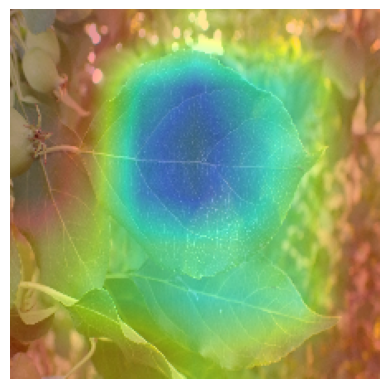

[Sample 2] True: Healthy | Pred: Healthy | Prob: 0.8935


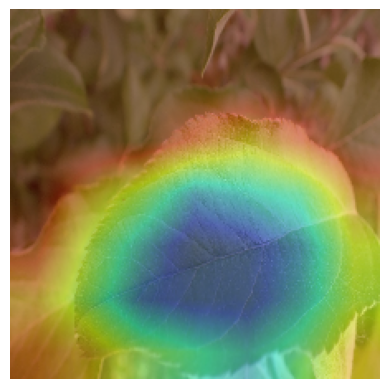


CLASS: Powdery (index 1) | found 2 samples
[Sample 1] True: Powdery | Pred: Powdery | Prob: 0.9972


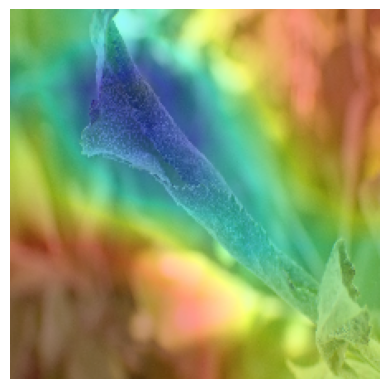

[Sample 2] True: Powdery | Pred: Powdery | Prob: 0.9010


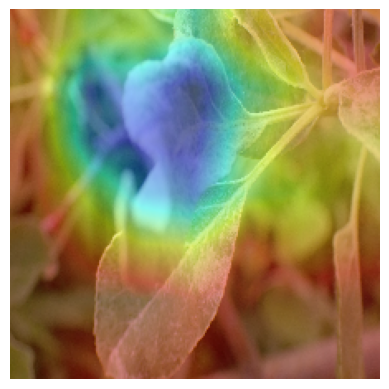


CLASS: Rust (index 2) | found 2 samples
[Sample 1] True: Rust | Pred: Rust | Prob: 0.9999


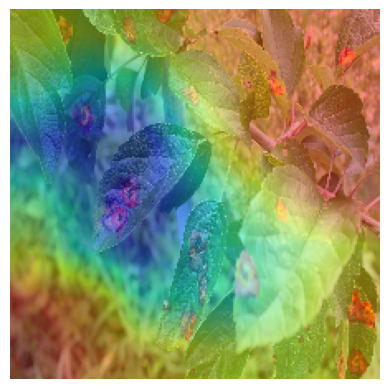

[Sample 2] True: Rust | Pred: Rust | Prob: 0.9999


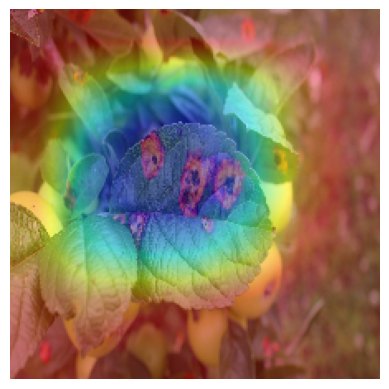

In [20]:
n_per_class = 2

samples_dict = collect_samples_per_class(
    dataset=val_ds_pf,
    class_names=class_names,
    n_per_class=n_per_class,
    max_batches=80
)

show_gradcam_samples_all_classes(
    samples_dict=samples_dict,
    class_names=class_names,
    grad_model=grad_model,
    n_per_class=n_per_class
)
